# E-commerce — Выявление профилей потребления

## Материалы
[Презентация](https://disk.yandex.ru/i/eSL3QLEZAQS75Q)

[Дашборд](https://public.tableau.com/views/e-commerce-dash/e-commerce-dash?:language=en-US&:display_count=n&:origin=viz_share_link)

Интернет-магазин товаров для дома «Пока все ещё тут» в срочном порядке ищет аналитиков. Вы поможете нашему магазину стать лучше, а клиентам — обустроить дом своей мечты. Наши ближайшие задачи — анализ товарного ассортимента и создание гипотез на основе полученных данных. «Пока все ещё тут» — мы создаём уют!

**Описание данных:** Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока
все ещё тут». 

Колонки в датасете:
- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

## Декомпозиция

###  Задача
Сегментировать покупателей на основании истории их покупок. 

### Цель
Для того, чтобы компания могла более точно настраивать свои email-рассылки и обращаться к каждой группе покупателей с уникальными предложениями, акциями и коммуникацией. 

### Предобработка данных
- Проверим корректность наименований столбцов; переименуем их.
- Исследуем соответствие типов данных; приведем их к нужному типу.
- Проверим данные на наличие явных и неявных дубликатов; удалим дубликаты.
- Исследуем пропущенные значения; заполним или удалим их.
- Добавляем столбец со стоимостью: цену умножаем на количество.
- Категоризируем товары по их наименованиям.

### EDA
- Исследуем временной интервал, за который собраны данные.
- Исследуем распределение данных.
- Исследуем аномальные значения.
- Сгруппируем датасет по customer_id и рассчитаем признаки, которые будем использовать для кластеризации и сравнения полученных кластеров между собой.
- Исследуем данные на наличие корреляций.

### Сегментация покупателей
Будем использовать ML для сегментации покупателей. Для этого: сгруппируем датасет по customer_id. Признаки, которые будем использовать для обучения и проверки модели:
- общая стоимость заказов;
- количество заказов;
- среднее количество купленных товаров;
- средний чек (средняя стоимость заказа);
- средняя цена товара.

Стандартизируем данные. Определим количество кластеров с помощью дендрограммы. Затем воспользуемся моделью k-means. Оценим различия между кластерами с помощью диаграмм рассеяния. Посчитаем метрики для нашей модели (например, с помощью метрики силуэта).

Сравним кластеры между собой по их признакам и дополнительно по:
- категориям покупаемых товаров;
- временному интервал между заказами (в количестве дней);
- давности совершения последнего заказа.

Исследуем сезонность.

### Проверка статистических гипотез
С помощью стат. критериев проверим имеют ли выделенные нами сегменты покупателей статистически значимые различия. Для проведения стат. тестов будем использовать либо t-критерий Стьюдента, либо критерий Шапиро-Уилка, в зависимости от того, как будут выглядеть наши данные после предобработки.

Сформулируем гипотезы:
- **Средний чек:**
  - H0: Нет различий между средним чеком покупателей из кластера X и средним чеком покупателей из кластера Y.
  - H1: Есть различия между средним чеком покупателей из кластера X и средним чеком покупателей из кластера Y.

- **Средняя цена купленных товаров:**
  - H0: Нет различий между средней ценой купленного товара у покупателей из кластера X и средней ценой купленного товара у покупателей из кластера Y.
  - H1: Есть различия между средней ценой купленного товара у покупателей из кластера X и средней ценой купленного товара у покупателей из кластера Y.
  
### Выводы
Составим портреты покупателей каждого из кластеров. Сформулируем рекомендации для настройки e-mail рассылок.

## Загрузка и предобработка данных

In [1]:
import pandas as pd
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import notebook
import numpy as np
import itertools
import random
from scipy import stats as st

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set_palette('muted')
sns.set_style('whitegrid')
sns.despine();

<Figure size 432x288 with 0 Axes>

In [2]:
pth1 = 'ecom_dataset_upd.csv'

pth2 = ''
try:
    df = pd.read_csv(pth1)
except FileNotFoundError:
    df = pd.read_csv(pth2)
except:
    print('Something is wrong')

In [3]:
display(df.info(), df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


None

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [4]:
# столбец с датой приведем к типу datetime и добавим столбец с месяцем
df['date'] = df['date'].apply(lambda row: datetime.strptime(str(row), '%Y%m%d%H').replace(hour=0, minute=0, second=0))
df['month'] = df['date'].apply(lambda row: row.replace(day=1))
df['month'] = df['month'].dt.date

In [5]:
# проверим данные на наличие дубликатов
display(df.duplicated().sum())

966

In [6]:
# удалим дубликаты
df= df.drop_duplicates().reset_index(drop=True)

In [7]:
# cоздаем список ключевых параметров для поиска неявных дубликатов
key_parameters = ['customer_id', 'order_id', 'product']

# проверяем наличие дубликатов по ключевым параметрам
display(df.duplicated(subset=key_parameters, keep=False).sum())

1307

In [8]:
# удалим дубликаты
df = df.drop_duplicates(subset=key_parameters, keep=False).reset_index(drop=True)

In [ ]:
# проверим данные на наличие задублировавшихся заказов у разных покупателей
len(df.groupby('order_id')['customer_id'].agg('nunique').reset_index().query('customer_id > 1'))

Т.к. мы не знаем кому именно из наших клиентов принадлежали задублировавшиеся заказы (первому по счету или второму и пр.), удалим эти повторы из датасета.

In [ ]:
# удалим эти заказы
orders_drop = list(df.groupby('order_id')['customer_id'].agg('nunique').reset_index().query('customer_id > 1')['order_id'])
df = df.loc[~df['order_id'].isin(orders_drop)]

In [9]:
# проверим данные на наличие пропусков
display(df.isna().sum())

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
month          0
dtype: int64

Пропуски в данных отсутствуют.

In [12]:
# добавим столбец со стоимостью
df['cost'] = df['price'] * df['quantity']

In [13]:
# категоризируем товары
# для этого посмотрим на уникальные значения первых слов столбца product
df['product_words'] = df['product'].apply(lambda row: ' '.join(row.split()[:1]).lower())
display(df['product_words'].unique())

array(['комнатное', 'радермахера', 'хризолидокарпус', 'циперус',
       'шеффлера', 'юкка', 'настенная', 'таз', 'чехол', 'вешалка',
       'сушилка', 'крючок', 'корзина', 'сумка-тележка', 'многолетнее',
       'рассада', 'муляж', 'щетка-сметка', 'сумка', 'тарелка', 'вилка',
       'ложка', 'нож', 'герань', 'ерш', 'пеларгония', 'котел',
       'суккулент', 'эхеверия', 'набор', 'коврик', 'подкладка', 'дозатор',
       'ёрш', 'эвкалипт', 'цветок', 'мусорный', 'плед', 'скатерть',
       'кувшин', 'адиантум', 'ковер', 'перчатки', 'стремянка',
       'гладильная', 'лестница-стремянка', 'толкушка', 'тележка',
       'готовая', 'искусственный', 'простыня', 'чайник', 'штора', 'банка',
       'стяжка', 'комплект', 'кампанула', 'декоративная', 'противень',
       'калатея', 'нолина', 'плечики', 'подушка', 'полотенце',
       'хлорофитум', 'цикламен', 'глоксиния', 'азалия', 'гортензия',
       'хризантема', 'петля', 'стеклянная', 'салфетка', 'вкладыши',
       'миксер', 'кофр', 'стиральный', 'чист

In [14]:
# создадим соответствующий словарь для категоризации
dict_category = {'plants': ['комнатное', 'радермахера', 'хризолидокарпус', 'циперус', 'шеффлера', 'юкка', 'многолетнее',
                            'рассада', 'герань', 'пеларгония', 'суккулент', 'эхеверия', 'эвкалипт', 'цветок', 'адиантум', 
                            'кампанула', 'калатея', 'нолина', 'хлорофитум', 'цикламен', 'глоксиния', 'азалия', 'гортензия',
                            'хризантема', 'мирт', 'цветущее', 'кориандр', 'иссоп', 'сантолина', 'аспарагус', 'афеляндра', 
                            'антуриум', 'молодило', 'фиалка', 'гербера', 'душица', 'мелисса', 'роза', 'бегония', 'розмарин', 
                            'альбука', 'бальзамин', 'крассула', 'артемизия', 'лаванда', 'мята', 'каланхое', 'примула', 
                            'дендробиум', 'калоцефалус', 'каллуна', 'капсикум', 'мимоза', 'соланум', 'бархатцы', 'космея', 
                            'морковь', 'настурция', 'огурец', 'петуния', 'алиссум', 'гвоздика', 'годеция', 'календула', 
                            'капуста', 'кореопсис', 'лапчатка', 'львиный', 'флокс', 'цинерария', 'эшшольция', 'диффенбахия', 
                            'фаленопсис', 'подсолнечник', 'пуансет', 'гиностемма', 'ель', 'кипарисовик', 'аптения', 
                            'фиттония', 'тимьян', 'пряные', 'девичий', 'лантана', 'литопс','клубника', 'ранункулус',
                            'спатифиллум', 'фикус', 'кодонанта', 'цикламен,', 'гимнокалициум', 'эхинокактус', 'алоэ', 
                            'крокусы', 'гипсофила', 'калибрахоа', 'эпипремнум','аквилегия','базилик', 'горох', 'земляника', 
                            'незабудка', 'седум', 'томат', 'укроп', 'нефролепис', 'калла', 'декабрист', 'тюльпан', 'гиацинт', 
                            'вербена', 'однолетнее', 'чабер', 'газания', 'овсянница', 'георгина', 'смолевка', 'цинния', 
                            'лавр', 'бакопа','виола', 'лилейник', 'папоротник', 'платикодон', 'энотера', 'фуксия', 
                            'цитрофортунелла', 'пеперомия', 'дыня', 'циния', 'синнингия', 'гардения','колокольчик',
                            'пиретрум', 'тагетис', 'муррайя', 'портулак', 'астра', 'аргирантерум', 'левкой', 'вероника', 
                            'целозия', 'маттиола', 'сальвия', 'лук', 'джункус', 'драцена','арбуз', 'фатсия', 'котовник', 
                            'хоста', 'гайлардия', 'монарда', 'нивянник', 'рудбекия', 'осина', 'сциндапсус', 'бузульник', 
                            'вербейник', 'камнеломка', 'солидаго', 'физостегия', 'ясколка', 'патиссон', 'цинерания', 
                            'лаватера', 'анемона', 'лен', 'буддлея', 'валериана', 'змееголовник', 'любисток','петрушка', 
                            'сельдерей', 'шалфей', 'хамедорея', 'зверобой', 'мединилла', 'импатиенс', 'клен', 'замиокулькас',
                            'амариллис', 'колеус', 'скиммия', 'пахира', 'лобелия'],
                 'furniture_and_appliances': ['кофр', 'карниз', 'подрукавник','подголов', 'комод', 'кондиционер', 'кипятильник',
                                             'этажерк', 'полк', 'модульн', 'обувниц', 'стеллаж', 'ванна', 'пуф', 'соковыжимал',
                                             'миксер', 'светильник', 'утюг', 'фен', 'овощеварк', 'мантовар', 'весы', 'соковар',
                                             'пылесос'],
                 'household_goods': ['таз', 'вешал', 'сушил', 'корзин', 'сум', 'котел', 'подклад', 'дозатор', 
                                    'перчат', 'стремян', 'гладильн', 'тележ', 'банк', 'стяж', 'плечик', 'петл', 'совок',
                                    'вкладыш','свер', 'контейнер', 'веник', 'швабр', 'ящик', 'ведр', 'короб', 'табак', 
                                    'сиденье', 'масленка', 'корыто', 'шнур', 'урна', 'сметка', 'линей', 'насад', 'фиксатор', 
                                    'средств', 'бензин', 'держател', 'проб', 'измельчит', 'лоток', 'губ', 'антижир', 'штанга',
                                    'универсальн', 'ролик','термометр', 'шило', 'ковш', 'кисточ', 'скребок', 'маск', 'пена',
                                    'рассекат', 'сетк', 'подставк', 'вантуз', 'ключница', 'лестница', 'тряпк', 'паста', 'мыло',
                                    'крепеж', 'штангенциркуль', 'бак','окномой', 'урна', 'щётка', 'кольц', 'ёрш', 'ополаскиват',
                                    'антинакипин', 'шпагат', 'бидон', 'корзин', 'прищеп', 'веревка', 'фал', 'пакет', 'ерш',
                                    'мешок', 'руч', 'инструмент','пьезозажигалка', 'решетка', 'шпингалет', 'нетканые', 'мусор',
                                    'концентр', 'отбеливат', 'стиральн', 'чистящ', 'крюч', 'угольн', 'угол', 'сварка',
                                    'муляж','искусствен', 'декоратив', 'фоторам', 'ваза', 'кашпо', 'зубн', 'мыльн', 'щетка'],
                 'textile_and_carpets': ['чехол', 'плед', 'скатерть', 'простын', 'штор', 'комплект', 'подушка', 'халат',
                                        'покрывал', 'одеял', 'махров','ткань', 'наматрацник', 'бельевые', 'наволоч', 'ковёр', 
                                        'ковер', 'пододеяльник','наматрасник', 'полотен', 'постельн', 'ковр', 'коврик'], 
                 'kitchen_utensils': ['тарел', 'вилка', 'ложка', 'нож', 'кувшин', 'tермокружка', 'орехоколка', 'посуд',
                                     'толкушка', 'ножеточка','противень', 'отделитель','салфетка','сервировочная', 'кофе',
                                     'салатник', 'сковорода', 'чай', 'рыбочистк', 'овощечистка', 'терка', 'круж', 'лопат', 
                                     'салфетница', 'стакан', 'столов', 'кухон', 'Tepмокружка', 'Термокружка', 'форм',
                                     'картофелемялка', 'термостакан', 'термос', 'сахарниц', 'салат', 'фужер', 'бокал', 
                                     'прибор', 'соус', 'пресс', 'емкость', 'крышка', 'блюдо', 'сотейник', 'венчик', 'сито',
                                     'доска', 'фарфоровая', 'столов', 'бульонниц', 'разделочная', 'просеивател', 'половник',
                                     'кастрюл', 'хлебниц', 'блюдце', 'мис']}

In [15]:
# напишем соответствующую функцию 
def make_category(row):
    """Эта функция категоризирует товары по следующим категориям: растения, мебель и техника, хозтовары, 
    текстиль и ковры, кухонные принадлежности"""
    
    for key,value in dict_category.items():
        for substring in value:
            pattern = r'\b' + substring + r'\w*'
            if len(re.findall(pattern, row, re.IGNORECASE)) != 0:
                return key
            else:
                pass

In [16]:
# применим функцию к датасету
df['product_category'] = df['product'].apply(make_category)

In [17]:
# проверим равномерно ли распределились цены товаров по категориям
display(df.groupby('product_category')['price'].agg(['mean', 'min','max']))

,mean,min,max
product_category,,,
furniture_and_appliances,1160.230769,157.0,4312.0
household_goods,1060.503902,15.0,14917.0
kitchen_utensils,372.274194,14.0,2399.0
plants,154.355402,9.0,7679.0
textile_and_carpets,942.376190,38.0,6134.0


Видим, что самая большая разница получилась в хозтоварах. Разделим эту категорию дополнительно по средней цене.

In [18]:
# найдем среднюю цену хозтоваров и разделим эту категорию на две группы
mean_price_hg = df[df['product_category'] == 'household_goods'][['price']].mean().loc['price']
df.loc[(df['product_category'] == 'household_goods') & (df['price'] <= mean_price_hg), 'product_category']\
= 'low_household_goods'
df.loc[(df['product_category'] == 'household_goods') & (df['price'] > mean_price_hg), 'product_category']\
= 'high_household_goods'

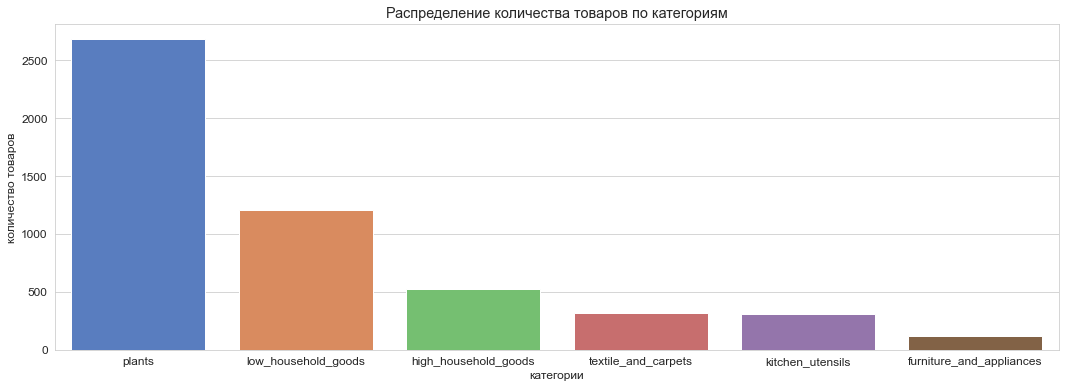

In [19]:
# визуализируем разбивку на категории по количеству товаров в них
plt.figure(figsize=(18, 6))
plt.rc('font', size=12)

fig = (sns.barplot(x='product_category', y='product', data=df.groupby('product_category')['product']
                   .agg('count').reset_index().sort_values(by='product', ascending=False)))
        
fig.set_title('Распределение количества товаров по категориям')
fig.set_xlabel('категории')
fig.set_ylabel('количество товаров')
plt.show() 

Видим, что большее количество купленных товаров приходится на растения.

In [20]:
# преобразуем полученные категории товаров в бинарные значения
encoded_category = pd.get_dummies(df['product_category'])
df_encoded = pd.concat([df, encoded_category], axis=1)
df_encoded.drop(['product', 'product_words', 'product_category'], axis=1, inplace=True)

In [21]:
display(df_encoded.info(), df_encoded.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5153 entries, 0 to 5200
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      5153 non-null   datetime64[ns]
 1   customer_id               5153 non-null   object        
 2   order_id                  5153 non-null   int64         
 3   quantity                  5153 non-null   int64         
 4   price                     5153 non-null   float64       
 5   month                     5153 non-null   object        
 6   cost                      5153 non-null   float64       
 7   furniture_and_appliances  5153 non-null   uint8         
 8   high_household_goods      5153 non-null   uint8         
 9   kitchen_utensils          5153 non-null   uint8         
 10  low_household_goods       5153 non-null   uint8         
 11  plants                    5153 non-null   uint8         
 12  textile_and_carpets 

None

,date,customer_id,order_id,quantity,price,month,cost,furniture_and_appliances,high_household_goods,kitchen_utensils,low_household_goods,plants,textile_and_carpets
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,1,142.0,2018-10-01,142.0,0,0,0,0,1,0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,1,194.0,2018-10-01,194.0,0,0,0,0,1,0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,1,112.0,2018-10-01,112.0,0,0,0,0,1,0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,1,179.0,2018-10-01,179.0,0,0,0,0,1,0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,1,112.0,2018-10-01,112.0,0,0,0,0,1,0


## EDA

In [22]:
# исследуем временной интервал
print(f"Начальная дата: {df_encoded['date'].min()}\nКонечная дата: {df_encoded['date'].max()}")

Начальная дата: 2018-10-01 00:00:00
Конечная дата: 2020-01-31 00:00:00


In [23]:
# посмотрим гистограммы и посмотрим на распределение наших данных
# для этого напишем соответствующую функцию
def hist_plot(df, columns, bins=30, stat="density"):
    
    for x in notebook.tqdm(range(len(columns))):
        plt.subplot(len(columns), 1, x+1)
        fig = sns.histplot(df[columns[x]], bins=bins, stat=stat)
        plt.xlabel('')
        plt.xlabel('')
        plt.ylabel('')
        fig.set_title(' Гистограмма '+columns[x]) 
    plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

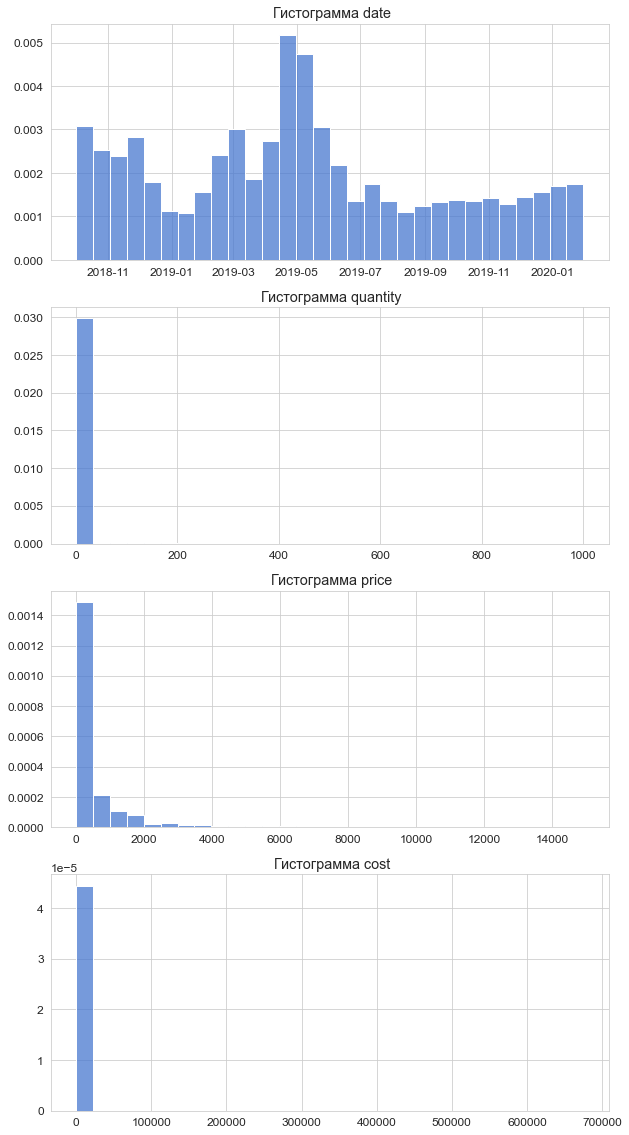

In [24]:
plt.figure(figsize=(10, 20))
plt.rc('font', size=12)

columns = ['date', 'quantity', 'price', 'cost']
hist_plot(df_encoded, columns)

Видим, что все признаки кроме даты имеют распределение, сильно скошенное вправо.

In [25]:
# посмотрим на распределение стоимости товаров по категориям
# для этого напишем соответствующую функцию
def box_plot(df, value, add, y_lim, index='product_category'):
    
    if y_lim == 0:
        fig = sns.boxplot(x=index, y=value, data=df)
    else:
        fig = sns.boxplot(x=index, y=value, data=df)
        plt.ylim(0, y_lim) 

    fig.set_title(add)
    fig.set_xlabel(value)
    fig.set_ylabel(index)
    plt.show()

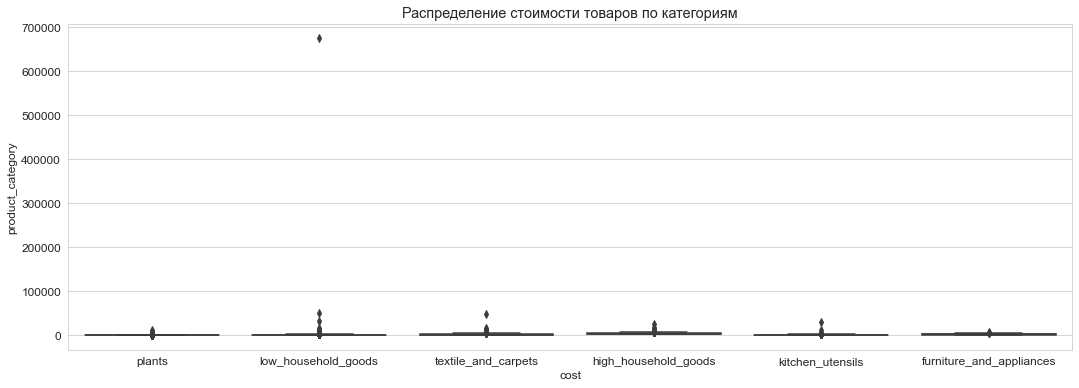

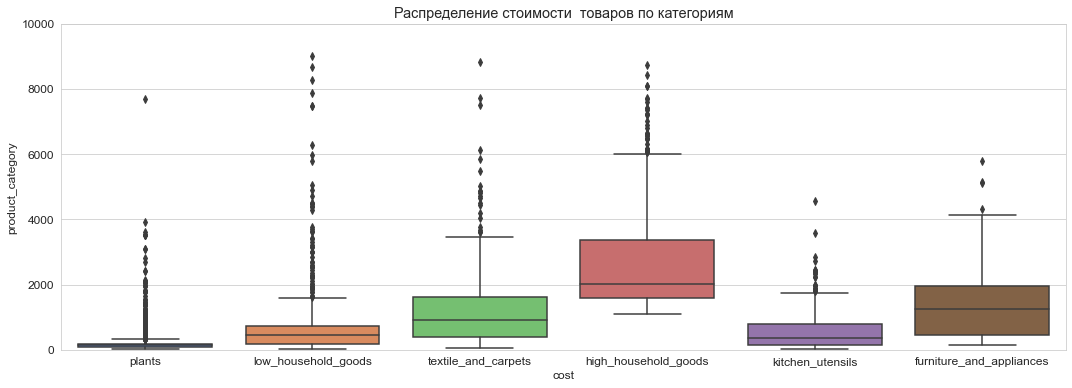

In [26]:
plt.figure(figsize=(18, 6))
plt.rc('font', size=12)
box_plot(df, 'cost', 'Распределение стоимости товаров по категориям', 0)

Видим, что сильную аномалию создают единичные покупки хозтоваров на сумму свыше 600 тысяч рублей.

In [27]:
# посмотрим на эти покупки
display(df.query('cost > 600000'))

,date,customer_id,order_id,product,quantity,price,month,cost,product_words,product_category
3517,2019-06-18,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,2019-06-01,675000.0,вантуз,low_household_goods


In [28]:
# удалим эту строку из наших данных
df = df.drop(3517)
df_encoded = df_encoded.drop(3517)

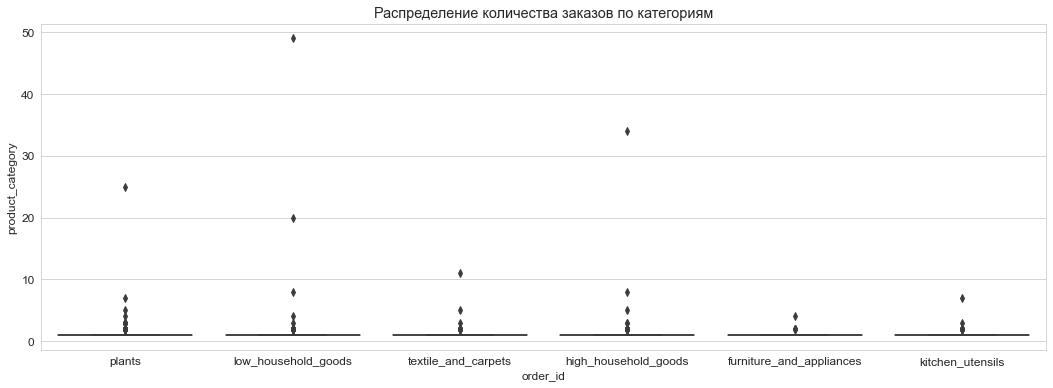

In [29]:
# посмотрим на распределение количества заказов по категориям
plt.figure(figsize=(18, 6))
plt.rc('font', size=12)
box_plot(df.groupby(['customer_id', 'product_category']).agg({'order_id': 'nunique'}).reset_index(), 'order_id', 
         'Распределение количества заказов по категориям', 0)

Видим, что аномалию создают более 20 заказов на покупателя.

In [30]:
# посмотрим на эти покупки
display(df.groupby(['customer_id']).agg({'order_id': 'nunique'}).reset_index().query('order_id >= 20'))

,customer_id,order_id
683,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35
1774,c971fb21-d54c-4134-938f-16b62ee86d3b,126


In [31]:
# удалим этих пользователей из наших данных
df = (df[(df['customer_id'] != '4d93d3f6-8b24-403b-a74b-f5173e40d7db') & 
         (df['customer_id'] != 'c971fb21-d54c-4134-938f-16b62ee86d3b')])
df_encoded = (df_encoded[(df_encoded['customer_id'] != '4d93d3f6-8b24-403b-a74b-f5173e40d7db') & 
                         (df_encoded['customer_id'] != 'c971fb21-d54c-4134-938f-16b62ee86d3b')])

In [32]:
# рассчитаем и добавим признаки для сегментации покапателей и последующей оценки получившихся кластеров
df_encoded_group_1 = (df_encoded.groupby('customer_id').agg({'cost': 'sum', 'order_id': 'nunique', 'quantity':'mean',
                                                             'price':'mean'}).reset_index())
df_encoded_group_1.rename(columns={'cost':'total_cost', 'order_id': 'cnt_orders', 'quantity': 'mean_quantity',
                                  'price': 'mean_price'}, inplace=True)
df_encoded_group_1 = df_encoded_group_1.sort_values(by='customer_id')

df_encoded_group_2 = ((df_encoded.groupby(['customer_id', 'order_id']).agg({'cost':'sum'}).reset_index())
                      .groupby('customer_id').agg({'cost':'mean'}).reset_index())
df_encoded_group_2.rename(columns={'cost': 'mean_cost', 'customer_id': 'customer_id_1'}, inplace=True)
df_encoded_group_2 = df_encoded_group_2.sort_values(by='customer_id_1')

df_encoded_group_3 = df_encoded.sort_values(by=['customer_id', 'date'])
df_encoded_group_3['date_diff'] = df_encoded_group_3.groupby('customer_id')['date'].diff().dt.days
df_encoded_group_3 = df_encoded_group_3.groupby('customer_id')['date_diff'].mean().fillna(0).reset_index()
df_encoded_group_3.rename(columns={'customer_id': 'customer_id_2'}, inplace=True)
df_encoded_group_3 = df_encoded_group_3.sort_values(by='customer_id_2')

df_encoded_group_4 = df_encoded.groupby('customer_id').agg({'date': 'min'}).reset_index()
df_encoded_group_4.rename(columns={'date': 'last_date', 'customer_id': 'customer_id_3'}, inplace=True)
df_encoded_group_4 = df_encoded_group_4.sort_values(by='customer_id_3')

df_encoded_concat = pd.concat([df_encoded_group_1, df_encoded_group_2, df_encoded_group_3, df_encoded_group_4], axis=1)
df_encoded_concat.drop(['customer_id_1', 'customer_id_2', 'customer_id_3'], axis=1, inplace=True)

  0%|          | 0/5 [00:00<?, ?it/s]

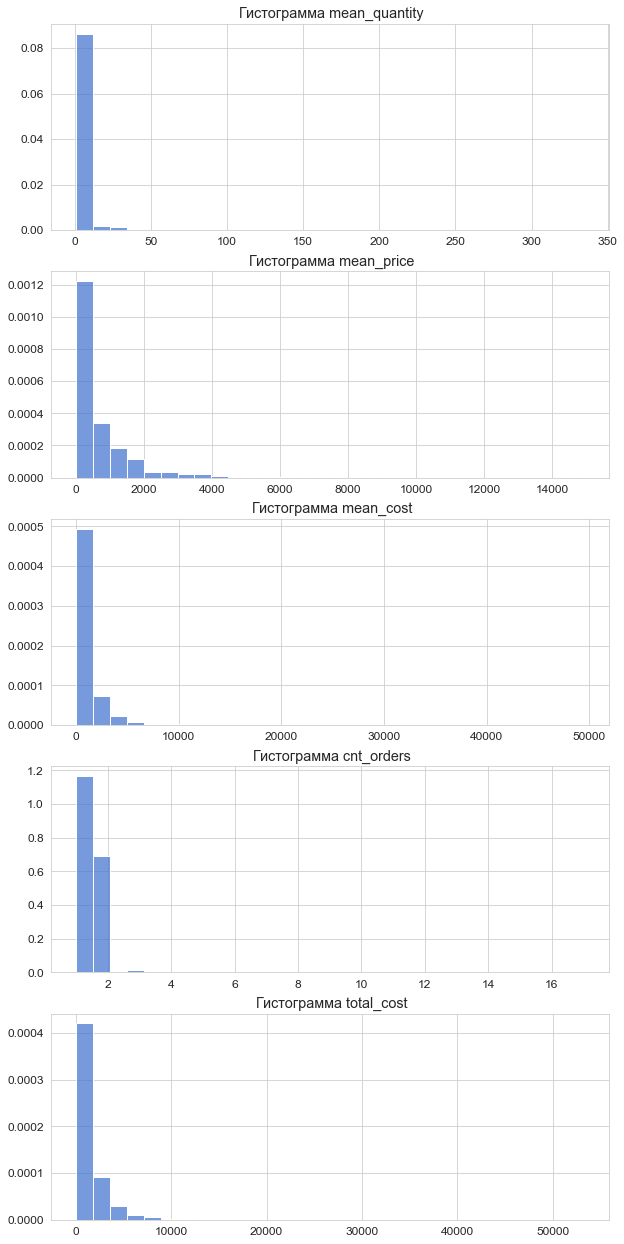

In [33]:
# посмотрим на распределение тех признаков, что будем использовать для кластеризации
plt.figure(figsize=(10, 22))
plt.rc('font', size=12)

columns = ['mean_quantity', 'mean_price', 'mean_cost', 'cnt_orders', 'total_cost']
hist_plot(df_encoded_concat, columns)

Видим, что все распределения имею длинные правые хвосты.

In [34]:
# определим их 90, 95 и 99 перцентили
print(f"""90-й, 95-й и 99-й перцентили для mean_quantity {np.percentile(df_encoded_concat['mean_quantity'],[90,95,99])}\n
90-й, 95-й и 99-й перцентили для mean_price {np.percentile(df_encoded_concat['mean_price'],[90,95,99])}\n
90-й, 95-й и 99-й перцентили для mean_cost {np.percentile(df_encoded_concat['mean_cost'],[90,95,99])}\n
90-й, 95-й и 99-й перцентили для cnt_orders {np.percentile(df_encoded_concat['cnt_orders'],[90,95,99])}\n
90-й, 95-й и 99-й перцентили для total_cost {np.percentile(df_encoded_concat['total_cost'],[90,95,99])}""")

90-й, 95-й и 99-й перцентили для mean_quantity [ 4.5  10.   40.81]

90-й, 95-й и 99-й перцентили для mean_price [1745.1  2699.   5128.55]

90-й, 95-й и 99-й перцентили для mean_cost [2562.6  3724.6  7619.14]

90-й, 95-й и 99-й перцентили для cnt_orders [2. 2. 3.]

90-й, 95-й и 99-й перцентили для total_cost [3408.4  4883.1  9238.18]


In [35]:
# дополнительно посмотрим на топ-10 самых крупных значений
display(df_encoded_concat['mean_quantity'].sort_values(ascending=False).head(10), 
        df_encoded_concat['mean_price'].sort_values(ascending=False).head(10),
        df_encoded_concat['mean_cost'].sort_values(ascending=False).head(10),
        df_encoded_concat['cnt_orders'].sort_values(ascending=False).head(10),
        df_encoded_concat['total_cost'].sort_values(ascending=False).head(10))

180     334.0
796     300.0
1468    200.0
1477    170.0
903     150.0
114     140.0
1919    100.0
1091    100.0
19      100.0
1246    100.0
Name: mean_quantity, dtype: float64

123     14917.0
1704     8737.0
1884     7724.0
2003     7679.0
2242     7597.0
1235     7349.0
402      7199.0
943      6899.0
1503     6865.5
1522     6614.0
Name: mean_price, dtype: float64

180     49432.0
1255    33680.0
909     32718.0
765     26616.0
244     24370.0
1262    16536.0
796     15300.0
123     14917.0
931     11250.0
1531    11000.0
Name: mean_cost, dtype: float64

1013    17
1619     7
17       5
1683     4
646      4
1987     4
2138     3
1846     3
577      3
119      3
Name: cnt_orders, dtype: int64

765     53232.0
180     49432.0
646     41900.0
1255    33680.0
909     32718.0
244     24370.0
1013    21361.0
1289    20232.0
2150    16557.0
1262    16536.0
Name: total_cost, dtype: float64

Видим, что хвостовые значения приходятся ~ на 1% наших данных. Сам 99 перцентиль близок к 10 значению в топе.

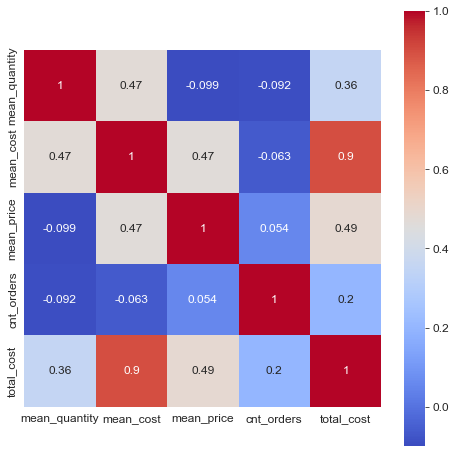

In [36]:
# посмотрим на матрицу корреляций наших признаков
plt.figure(figsize=(8, 8))
plt.rc('font', size=12) 

sns.heatmap(df_encoded_concat[['mean_quantity', 'mean_cost', 'mean_price', 'cnt_orders', 'total_cost']].corr(), 
            annot=True, square=True, cmap= 'coolwarm') 
plt.show()

Видим, что несколько признаков сильно коррелированы между собой; для чистоты работы модели **не** будем использовать следующие признаки при кластеризации: `total_cost`.

In [37]:
display(df_encoded_concat.info(), df_encoded_concat.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2274 entries, 0 to 2273
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   customer_id    2274 non-null   object        
 1   total_cost     2274 non-null   float64       
 2   cnt_orders     2274 non-null   int64         
 3   mean_quantity  2274 non-null   float64       
 4   mean_price     2274 non-null   float64       
 5   mean_cost      2274 non-null   float64       
 6   date_diff      2274 non-null   float64       
 7   last_date      2274 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 159.9+ KB


None

,customer_id,total_cost,cnt_orders,mean_quantity,mean_price,mean_cost,date_diff,last_date
0,000d6849-084e-4d9f-ac03-37174eaf60c4,555.0,1,1.0,138.75,555.0,0.0,2019-10-16
1,001cee7f-0b29-4716-b202-0042213ab038,442.0,1,1.0,442.00,442.0,0.0,2019-02-16
2,00299f34-5385-4d13-9aea-c80b81658e1b,914.0,1,2.0,457.00,914.0,0.0,2019-10-14
3,002d4d3a-4a59-406b-86ec-c3314357e498,1649.0,1,1.0,1649.00,1649.0,0.0,2019-01-27
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2324.0,1,2.0,1162.00,2324.0,0.0,2019-09-29


## Сегментация покупателей

In [38]:
# для того, чтобы оценить оптимальное число кластеров возьмем случайный сэмпл из исходных данных 
X = df_encoded_concat[['mean_quantity', 'mean_price', 'cnt_orders', 'mean_cost']].sample(400, random_state=0)

# стандартизируем данные
scaler = StandardScaler()
scaler.fit(X)
X_sc = scaler.transform(X)

linked = linkage(X_sc, method = 'ward') 

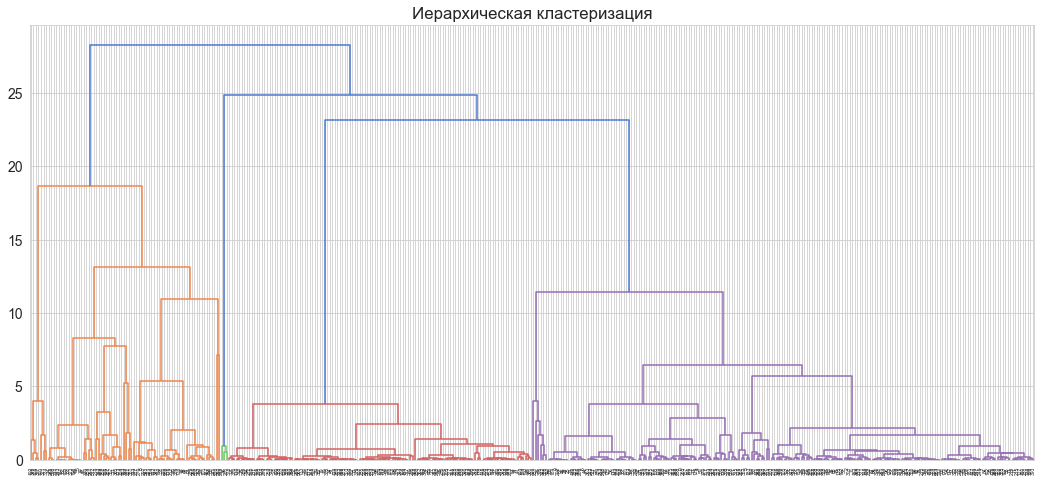

In [39]:
# и отрисуем дендрограмму
plt.figure(figsize=(18, 8))
plt.rc('font', size=14) 
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show();

Исходя из получившегося графика, оптимальное число кластеров равно четырем.

In [40]:
# проведем соответствующую кластеризацию
X = df_encoded_concat[['mean_quantity', 'mean_price', 'cnt_orders', 'mean_cost']].copy()

# стандартизируем данные
scaler = StandardScaler()
scaler.fit(X)
X_sc = scaler.transform(X)

# задаём модель k_means с оптимальным числом кластеров  
km = KMeans(n_clusters=4, random_state=0)

# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле сгруппированного датасета
df_encoded_concat['cluster_km'] = labels

In [41]:
# посчитаем метрику силуэта для проведенной кластеризации
e = round(silhouette_score(X_sc, labels), 2)
print(f'Silhouette_score: {e}')

Silhouette_score: 0.56


In [42]:
# внесем номера получившихся кластеров в поле исходного датасета
dict_customer_id = {k: v for k, v in zip(df_encoded_concat['customer_id'], df_encoded_concat['cluster_km'])}
df_encoded['cluster_km'] = df_encoded['customer_id'].apply(lambda row: dict_customer_id.get(row))

In [43]:
# напишем функцию для построения графиков попарных признаков для получившихся кластеров
def show_clusters_on_plot(df, cluster='cluster_km'):
    
    col_pairs = list(itertools.combinations(df.drop([cluster], axis=1).columns, 2))
    for x in notebook.tqdm(range(len(col_pairs))):
        plt.subplot(len(col_pairs), 1, x+1)
        fig = sns.scatterplot(x=df[col_pairs[x][0]], y=df[col_pairs[x][1]], hue=df[cluster])
        plt.xlabel('')
        plt.ylabel('')
        fig.set_title('Диаграмма рассеяния: '+col_pairs[x][0]+' vs '+col_pairs[x][1])
    plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

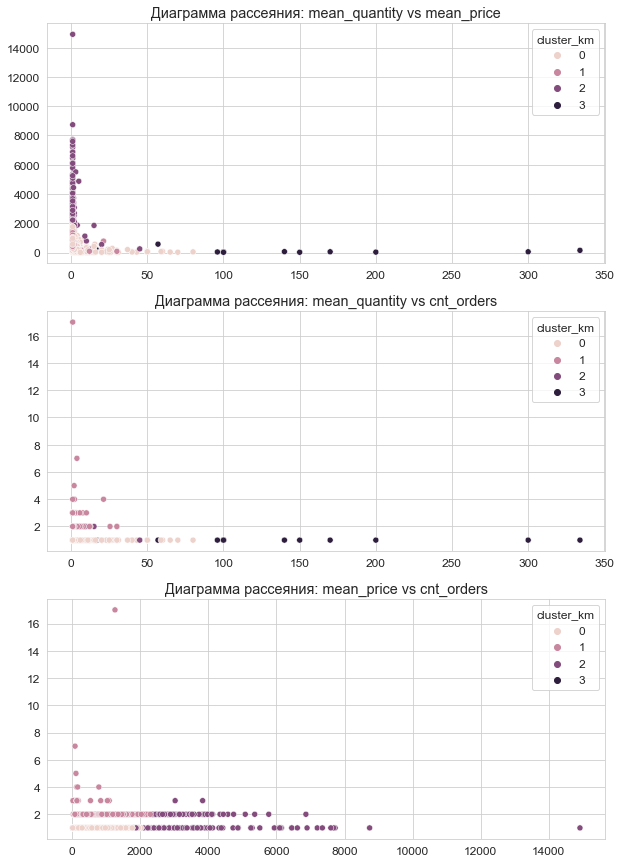

In [44]:
plt.figure(figsize=(10, 15))
plt.rc('font', size=12)

show_clusters_on_plot(df_encoded_concat[['cluster_km', 'mean_quantity', 'mean_price', 'cnt_orders']])

По диаграммам сложно сказать о наличии выраженного различия между кластерами.

In [46]:
# сделаем сводные таблицы для оценки получившихся кластеров
t = (df_encoded.groupby('cluster_km')[['furniture_and_appliances', 'low_household_goods', 'high_household_goods', 
                                             'kitchen_utensils', 'plants', 'textile_and_carpets']].mean())

t1 = (df_encoded_concat.groupby('cluster_km').agg({'customer_id': 'count', 'cnt_orders': 'mean', 'mean_quantity': 'mean', 
                                                   'mean_price': 'mean', 'mean_cost':'mean', 'total_cost': 'mean',
                                                   'date_diff': 'mean', 'last_date':lambda x: x.mode()[0]}))
display(t, t1)

,furniture_and_appliances,low_household_goods,high_household_goods,kitchen_utensils,plants,textile_and_carpets
cluster_km,,,,,,
0,0.013874,0.215407,0.041621,0.056955,0.629062,0.043081
1,0.032553,0.252798,0.109868,0.068159,0.458800,0.077823
2,0.045643,0.107884,0.622407,0.024896,0.082988,0.116183
3,0.000000,0.888889,0.000000,0.111111,0.000000,0.000000


,customer_id,cnt_orders,mean_quantity,mean_price,mean_cost,total_cost,date_diff,last_date
cluster_km,,,,,,,,
0,1296,1.000000,3.446094,420.344495,900.560957,900.560957,0.009645,2019-04-24
1,800,2.056250,1.322975,624.283410,701.618910,1476.832396,221.326483,2019-02-06
2,165,1.369697,1.774747,3537.152525,4507.791414,5991.354545,81.381818,2018-11-28
3,13,1.000000,143.371795,97.397436,13292.923077,13292.923077,0.000000,2018-10-01


Исходя из таблиц видим, что покупатели совершают в магазине всего одну-две покупки; при этом разница между покупками составляет ~ 6 месяцев. Более подробный анализ проведем по соответствующим графикам.

In [48]:
# построим графики для визуализации различий в кластерах
# для этого напишем соответствующие функции
def show_bar_plot(df, dict_agg, goal='cluster_km'):
    
    x = 0   
    for key,value in notebook.tqdm(dict_agg.items()):
        plt.subplot(len(dict_agg), 1, x+1)
        report = df.groupby(goal).agg({key: value}).reset_index()
        report.columns = [goal, key]
        fig = sns.barplot(x=goal, y=key, data=report)
        
        fig.set_title('Распределение '+key)
        fig.set_xlabel(goal)
        fig.set_ylabel(key)
        x+=1
    plt.show() 

def show_pie(df, columns, goal='cluster_km', figsize=(10, 30)):
    
    fig, axs = plt.subplots(len(df[goal].unique()), 1, figsize=figsize)
    
    for x in notebook.tqdm(range(len(df[goal].unique()))):
        report = df.loc[df[goal] == x][columns]
        report = report.mean().reset_index()
        report.columns = ['value', 'mean']
        report = report.sort_values(by='mean', ascending=False)
        
        axs[x].pie(report['mean'], labels=report['value'], autopct='%.1f%%')
        axs[x].set_title('Покупки кластера '+ str(x))
        axs[x].set_xlabel("")
        axs[x].set_ylabel("")
    plt.show()
    
def show_seasonal(df, columns, goal='cluster_km', ts='month', figsize=(18, 6)):
    
    for x in notebook.tqdm(range(len(df[goal].unique()))): 
        report = df.loc[df[goal] == x]
        report = report.groupby(ts)[columns].mean().reset_index()
        report.set_index(ts, inplace=True)
        
        fig, ax = plt.subplots(figsize=figsize)
        report.plot.bar(stacked=True, ax=ax)
        ax.set_title('Сезонность покупок. Кластер ' + str(x), fontsize=16)
        ax.set_xlabel('месяц')
        ax.set_ylabel('доля товаров', fontsize=12)
        ax.legend(loc='upper right', fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

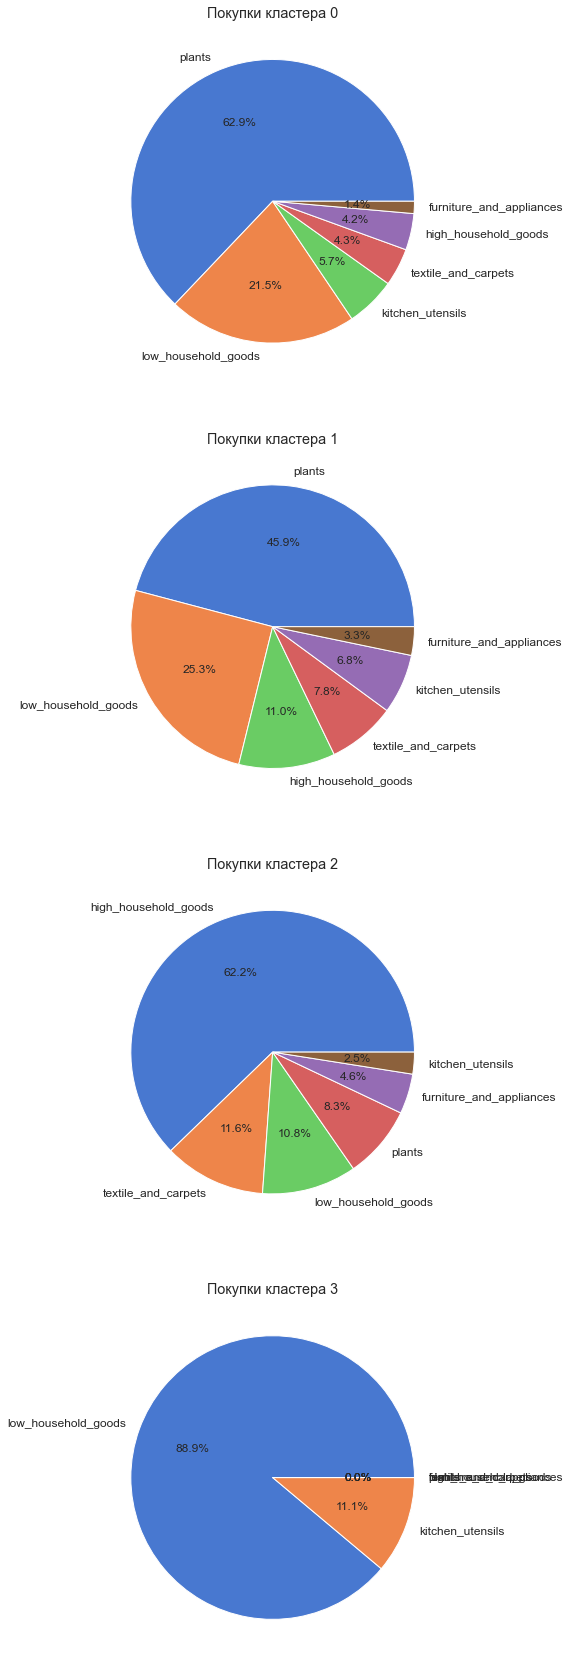

In [49]:
plt.rc('font', size=12)
show_pie(df_encoded, ['furniture_and_appliances', 'low_household_goods', 'high_household_goods', 'kitchen_utensils', 
                             'plants', 'textile_and_carpets'])

- Кластер 3: Большая часть покупок приходится на не дорогие хозтовары; остальные доли товаров намного менее значительны.
- Кластер 1: Большая часть покупок приходится на растения и не дорогие хозтовары.
- Кластер 2: Большая часть покупок приходится на дорогие хозтовары; остальные доли товаров намного менее значительны.
- Кластер 0: Большая часть покупок приходится на растения, на втором месте - не дорогие хозтовары.

  0%|          | 0/4 [00:00<?, ?it/s]

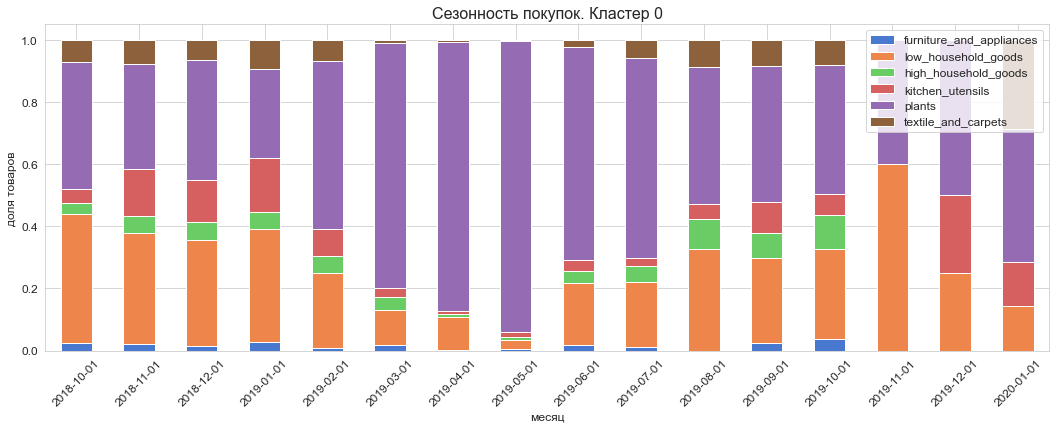

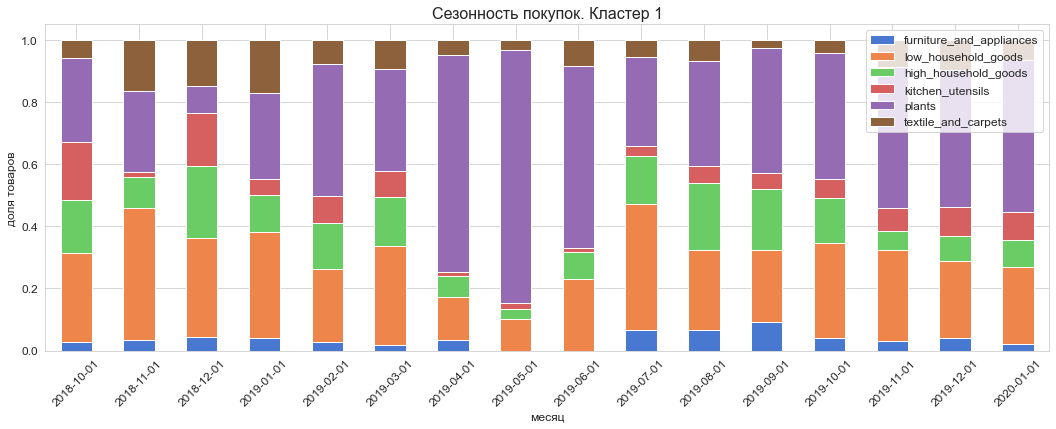

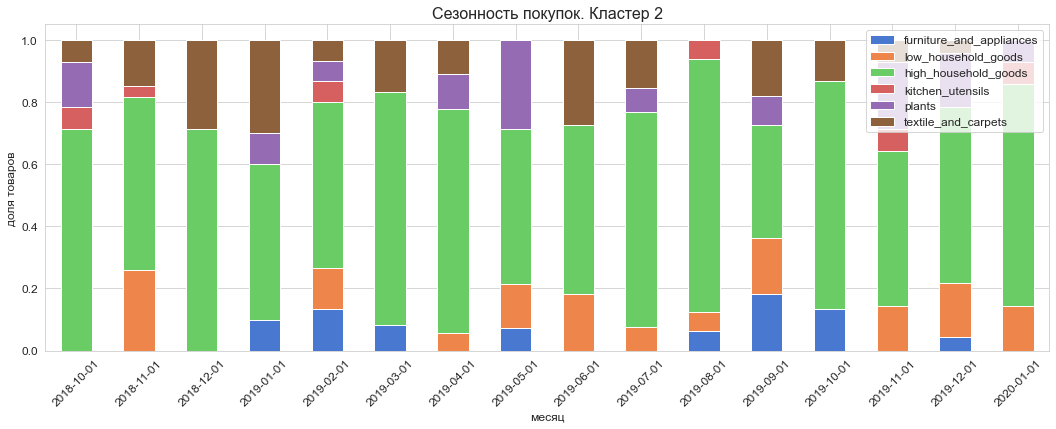

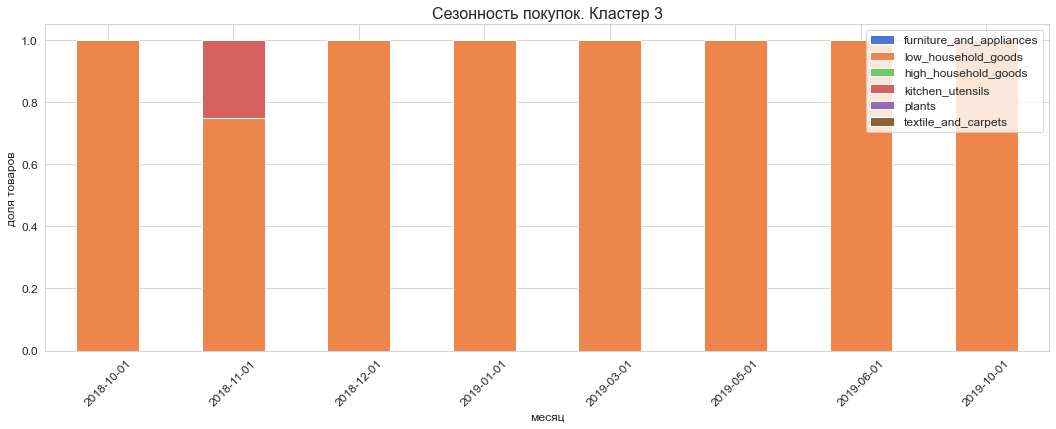

In [50]:
show_seasonal(df_encoded, ['furniture_and_appliances', 'low_household_goods', 'high_household_goods', 
                                        'kitchen_utensils', 'plants', 'textile_and_carpets'])

- Кластер 3: Покупка не дорогих хозтоваров не зависит от сезона.
- Кластер 1: Основная доля покупок приходится на растения в месяцы с 4 по 6. В остальное время года - это, в основном, не дорогие и дорогие хозтовары и комнатные растения.
- Кластер 0: Основная доля покупок приходится на растения в месяцы с 3 по 7. В остальное время года - это в основном не дорогие хозтовары, комнатные растения и кухонные принадлежности.
- Кластер 2: Покупка дорогих хозтоваров не зависит от сезона.

  0%|          | 0/6 [00:00<?, ?it/s]

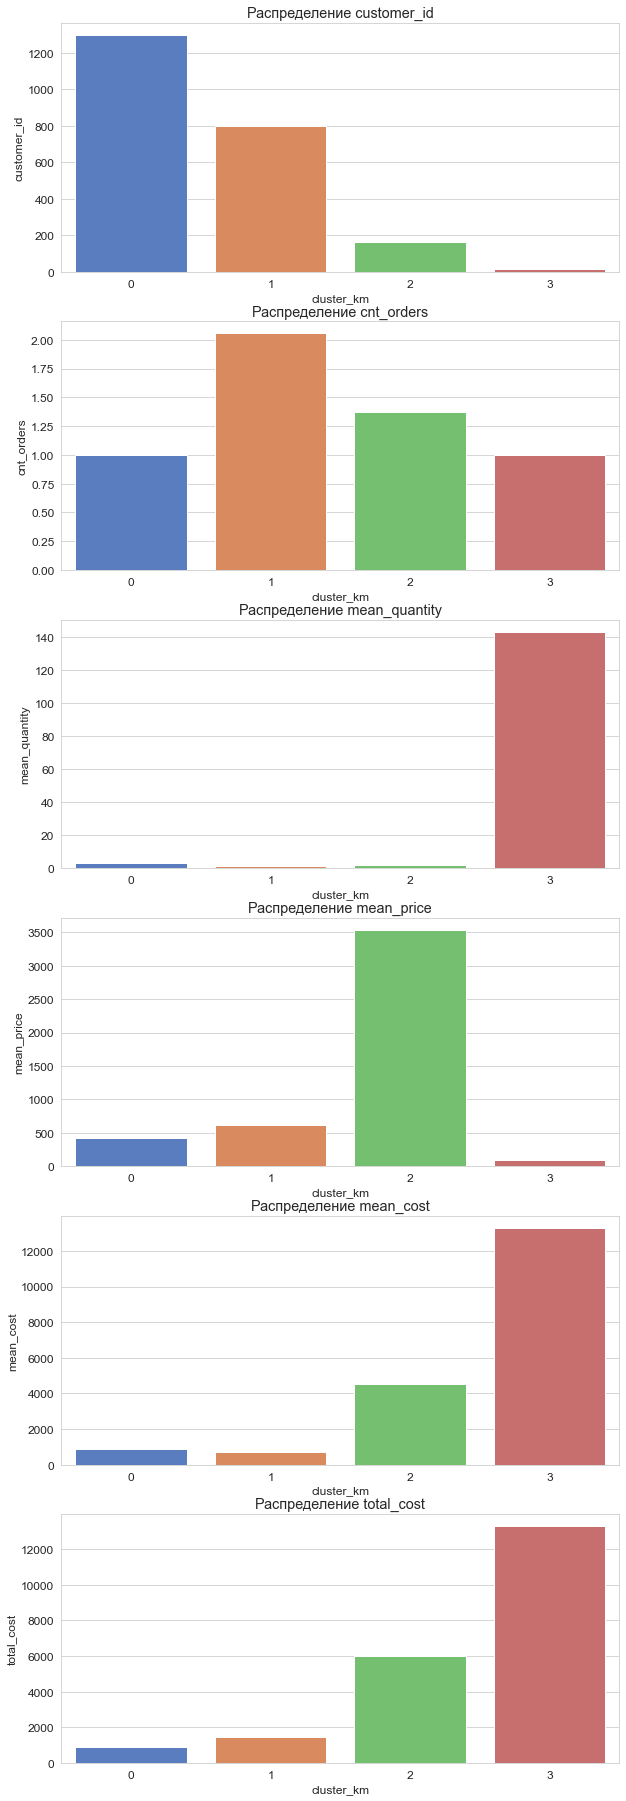

In [51]:
dict_agg = ({'customer_id': 'count', 'cnt_orders': 'mean', 'mean_quantity': 'mean', 
            'mean_price': 'mean', 'mean_cost':'mean', 'total_cost': 'mean'})

plt.figure(figsize=(10, 32))
plt.rc('font', size=12)
show_bar_plot(df_encoded_concat, dict_agg)

- Кластер 0 наиболее крупный по количеству покупателей в нем. Эти покупатели заказывали небольшое количество недорогих товаров; как следствие - имеют низкий средний чек; в основном заказывали в магазине лишь единожды.
- Кластер 1 похож на нулевой кластер; отличие заключается в том, что покупатели из этого кластера чаще возвращались за покупками в магазин.
- Кластер 2 - небольшой по количеству покупателей в нем . Эти покупатели заказывали небольшое количество дорогих товаров; средний чек у них высокий; в основном заказывали в магазине лишь единожды.
- Кластер 3 - самый маленький по количеству покупателей в нем. Эти покупатели заказывали большое количество недорогих товаров; имеют высокий средний чек; в основном заказывали в магазине лишь единожды.

## Проверка статистических гипотез
С помощью стат. критериев проверим имеют ли выделенные нами сегменты покупателей статистически значимые различия. 

### Гипотеза 1
Сформулируем общие положения:
  - H0: Нет различий между средним чеком покупателей из кластера X и средним чеком покупателей из кластера Y.
  - H1: Есть различия между средним чеком покупателей из кластера X и средним чеком покупателей из кластера Y.

In [52]:
# посмотрим на распределение наших выборок
# для этого напишем соответствующую функцию 
def hist_plot_combin(df, columns, goal='cluster_km', stat="density"):
    
    combin = list(itertools.combinations(set(df[goal]), 2))
    for i in notebook.tqdm(range(len(combin))):
        plt.figure(figsize=(20, 9))
        plt.rc('font', size=14)
        df1 = df[df[goal] == combin[i][0]]
        df2 = df[df[goal] == combin[i][1]]
        for x in range(len(columns)):
            plt.subplot(len(columns)*2, 2, x*2+1)
            fig = sns.histplot(df1[columns[x]], stat=stat)
            plt.xlabel('')
            plt.ylabel('')
            fig.set_title('Кластер '+str(combin[i][0])+'. Гистограмма по '+columns[x]) 
            
            plt.subplot(len(columns)*2, 2, x*2+2)
            fig = sns.histplot(df2[columns[x]], stat=stat)
            plt.xlabel('')
            plt.ylabel('')
            fig.set_title('Кластер '+str(combin[i][1])+'. Гистограмма по '+columns[x])
        plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

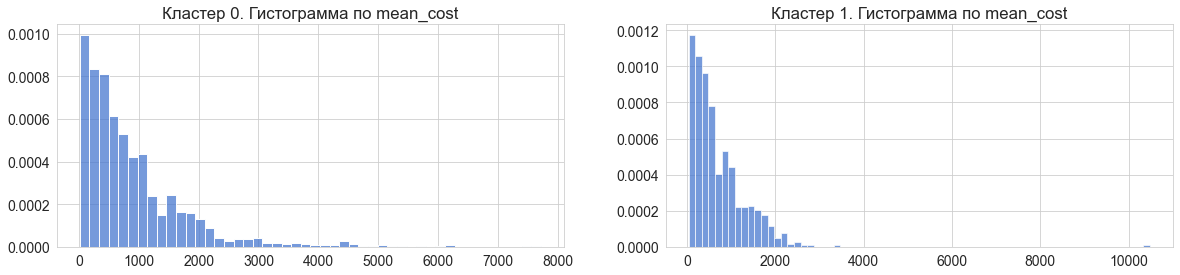

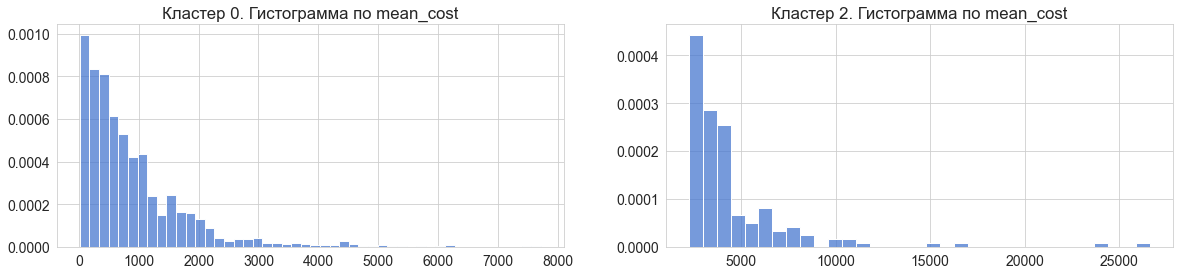

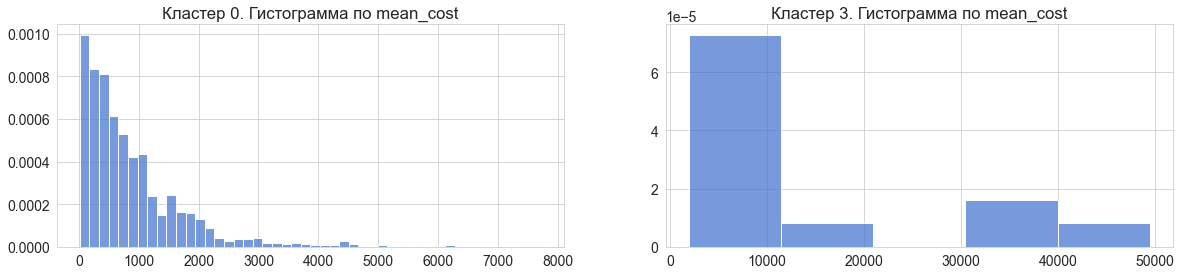

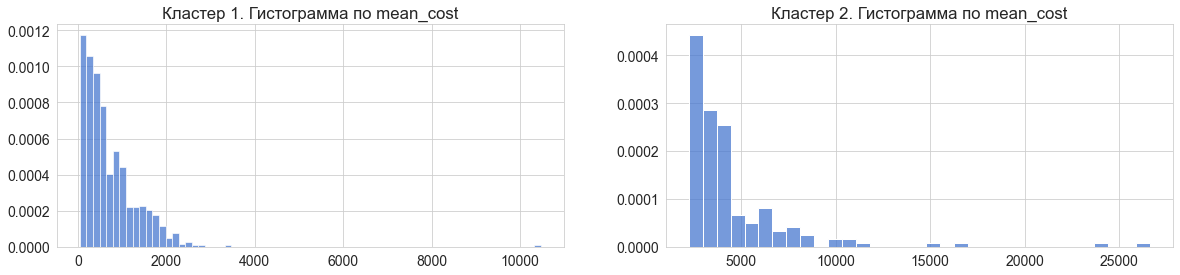

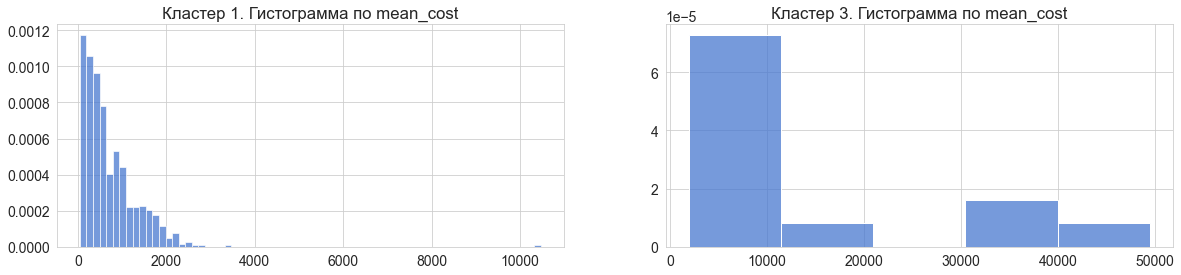

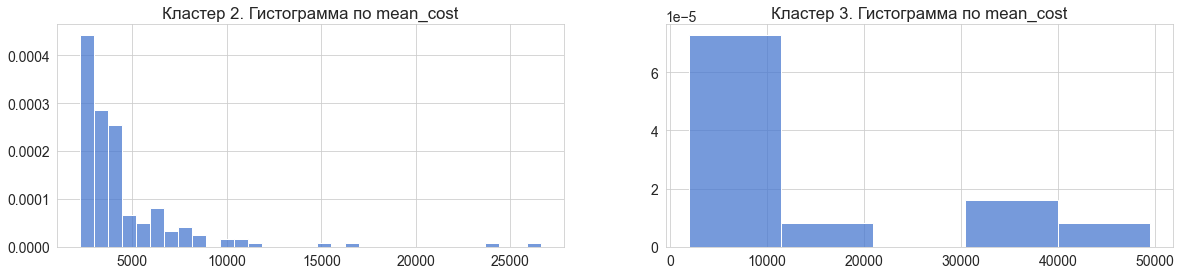

In [53]:
hist_plot_combin(df_encoded_concat, ['mean_cost'])

Т.к. распределения всех выборок далеки от нормального, проверим, как распределены их выборочные средние.

In [54]:
# напишем функцию, которая заполнит пустые списки выборочными средними наших выборок и отрисует соотв. гистограммы
def check_sample_avg_combin(df, value, goal='cluster_km', stat="density"):
    
    combin = list(itertools.combinations(set(df[goal]), 2))
    for i in notebook.tqdm(range(len(combin))):
        plt.figure(figsize=(20, 9))
        plt.rc('font', size=14)
        df1 = df[df[goal] == combin[i][0]]
        df2 = df[df[goal] == combin[i][1]]

        sample_X = df1[value].dropna().tolist()
        sample_Y = df2[value].dropna().tolist()
        
        random.seed(0)
        
        sample_means_X = []
        sample_means_Y = []
        sample_cnt = 10000
        sample_size = 100
        
        for _ in range(sample_cnt):
            sample = random.choices(sample_X, k=sample_size)
            sample_mean = np.mean(sample)
            sample_means_X.append(sample_mean)
            
        for _ in range(sample_cnt):
            sample = random.choices(sample_Y, k=sample_size)
            sample_mean = np.mean(sample)
            sample_means_Y.append(sample_mean)
            
        df_X, df_Y = pd.DataFrame(sample_means_X), pd.DataFrame(sample_means_Y)
        df_X.columns, df_Y.columns = [value], [value]
            
        for x in range(1):
            plt.subplot(1*2, 2, x*2+1)
            fig = sns.histplot(df_X[value], stat=stat)
            plt.xlabel('')
            plt.ylabel('')
            fig.set_title('Кластер '+str(combin[i][0])+'. Гистограмма выборочных средних по '+value) 
            
            plt.subplot(1*2, 2, x*2+2)
            fig = sns.histplot(df_Y[value], stat=stat)
            plt.xlabel('')
            plt.ylabel('')
            fig.set_title('Кластер '+str(combin[i][1])+'. Гистограмма выборочных средних по '+value)
        plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

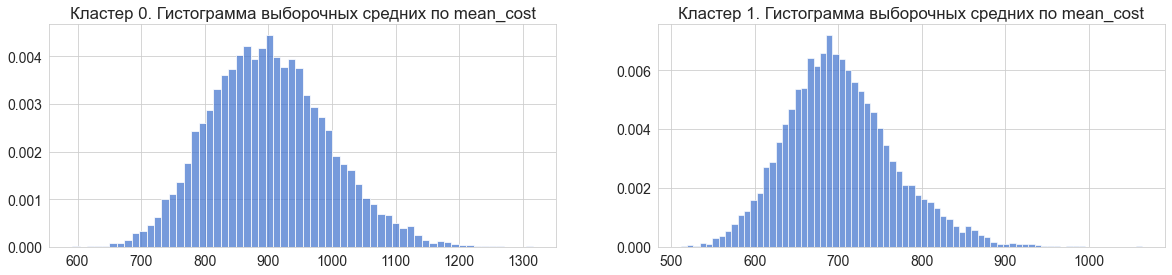

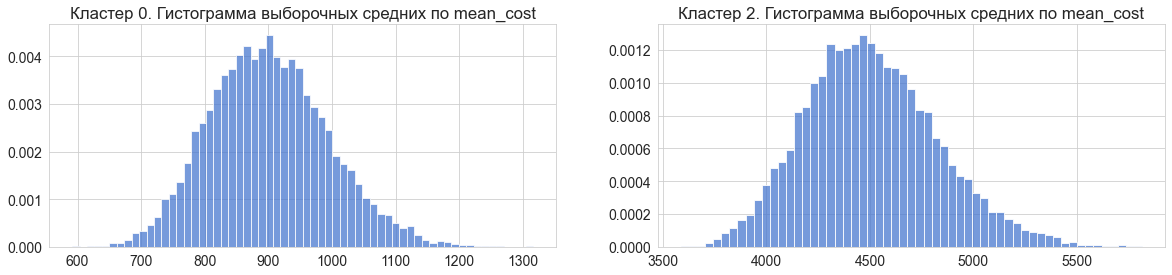

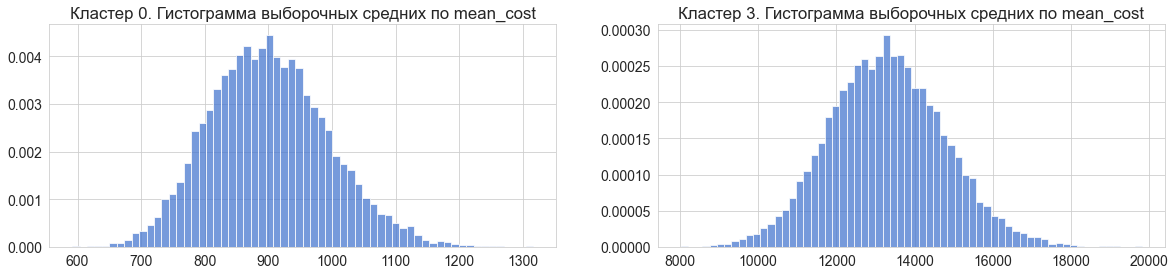

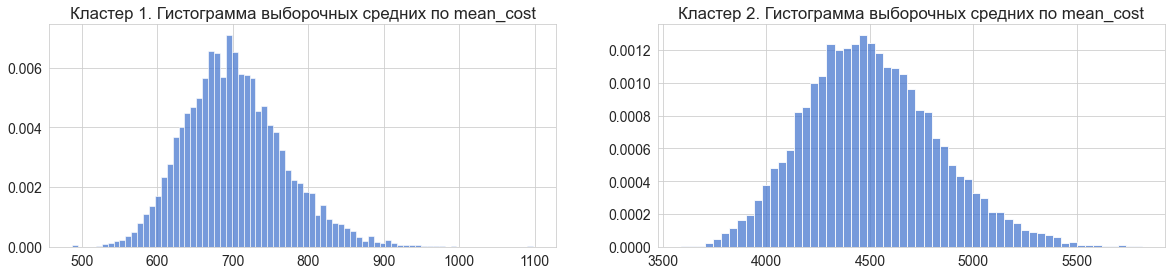

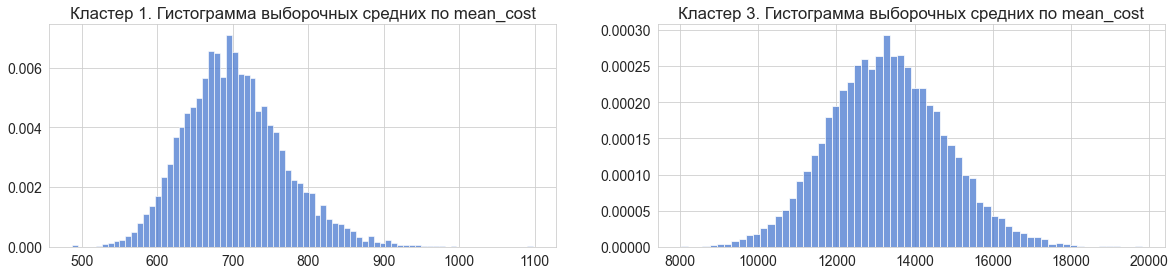

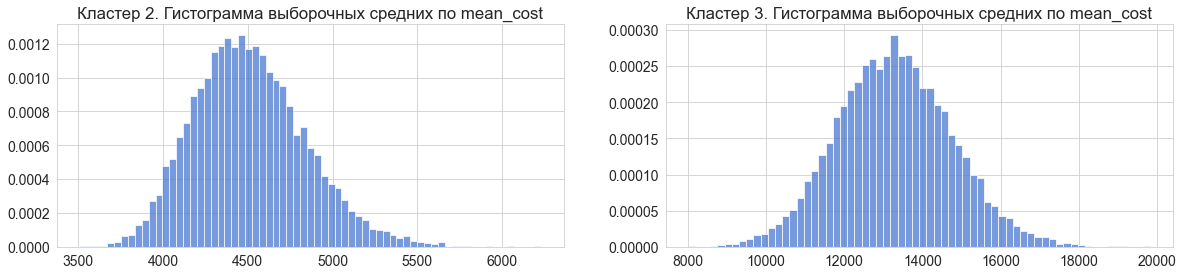

In [55]:
check_sample_avg_combin(df_encoded_concat, 'mean_cost')

Видим, что распределения выборочных средних близки к нормальным; но, также, знаем, что одна из наших выборок слишком маленького размера для применения T-теста. Поэтому воспользуемся тестом Манна-Уитни. 

In [56]:
# для этого напишем соответствующую функцию
def make_m_test_combin(df, value, goal='cluster_km', alpha=0.05, m=1):
    
    combin = list(itertools.combinations(set(df[goal]), 2))
    for i in notebook.tqdm(range(len(combin))):
        df1 = df[df[goal] == combin[i][0]][value]
        df2 = df[df[goal] == combin[i][1]][value]
        
        sample_1 = df1.dropna().tolist()
        sample_2 = df2.dropna().tolist()
        
        n = i+1
        k = m-n+1
        alpha_k = alpha / k # уровень статистической значимости с учетом поправки Холма
        
        results = st.mannwhitneyu(sample_1, sample_2)[1]
        
        print('Результаты теста '+str(n)+'. Кластеры: '+str(combin[i][0])+' и '+str(combin[i][1]))
        print('p-value:', results)
        
        if results < alpha_k:
            print('Отвергаем нулевую гипотезу')
        else:
            print('Не получилось отвергнуть нулевую гипотезу') 

In [57]:
make_m_test_combin(df_encoded_concat, 'mean_cost', m=6) 

  0%|          | 0/6 [00:00<?, ?it/s]

Результаты теста 1. Кластеры: 0 и 1
p-value: 0.00048492176440276583
Отвергаем нулевую гипотезу
Результаты теста 2. Кластеры: 0 и 2
p-value: 4.851622910219333e-87
Отвергаем нулевую гипотезу
Результаты теста 3. Кластеры: 0 и 3
p-value: 2.575879253707847e-09
Отвергаем нулевую гипотезу
Результаты теста 4. Кластеры: 1 и 2
p-value: 3.7691198487016356e-90
Отвергаем нулевую гипотезу
Результаты теста 5. Кластеры: 1 и 3
p-value: 8.414394303888649e-10
Отвергаем нулевую гипотезу
Результаты теста 6. Кластеры: 2 и 3
p-value: 0.03134613693344263
Отвергаем нулевую гипотезу


**Вывод:** В среднем чеке покупателей из всех наших кластеров есть статистически значимые различия.

### Гипотеза 2
Сформулируем общие положения:
  - H0: Нет различий между средней ценой купленного товара у покупателей из кластера X и средней ценой купленного товара у покупателей из кластера Y.
  - H1: Есть различия между средней ценой купленного товара у покупателей из кластера X и средней ценой купленного товара у покупателей из кластера Y.

  0%|          | 0/6 [00:00<?, ?it/s]

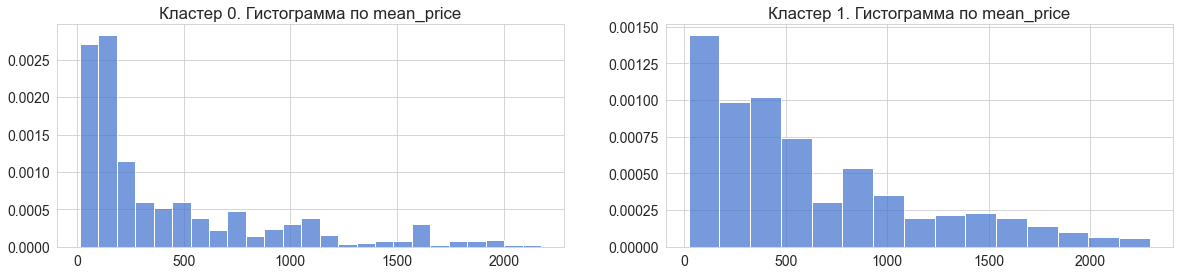

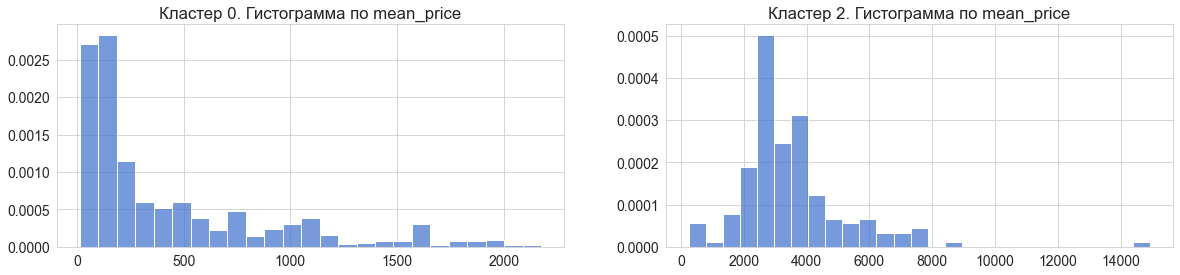

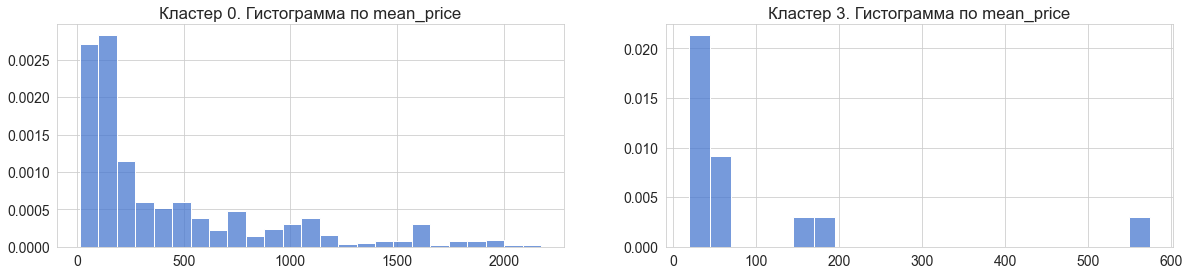

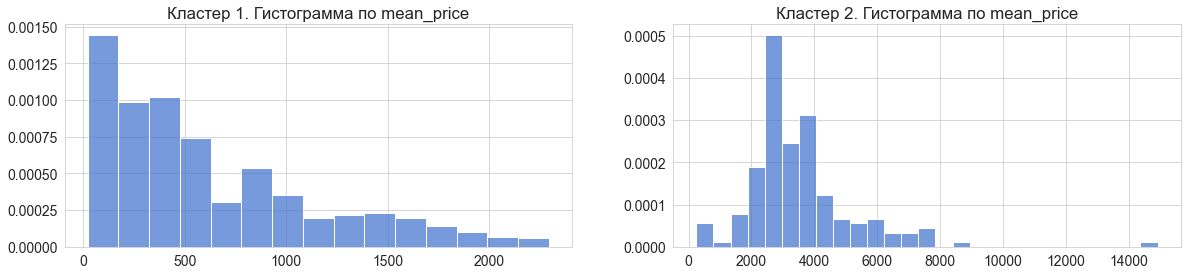

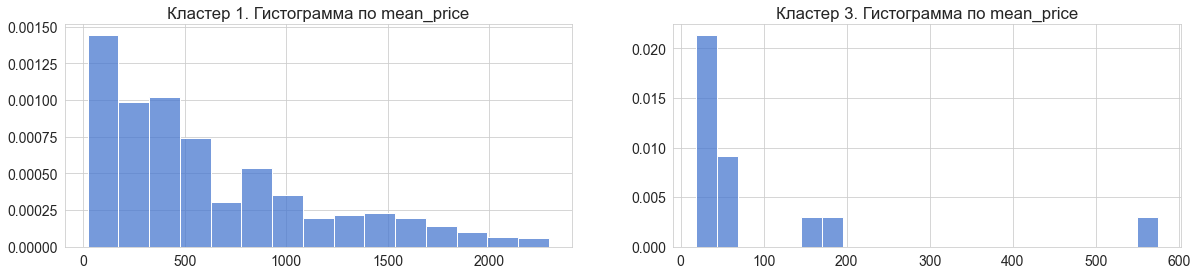

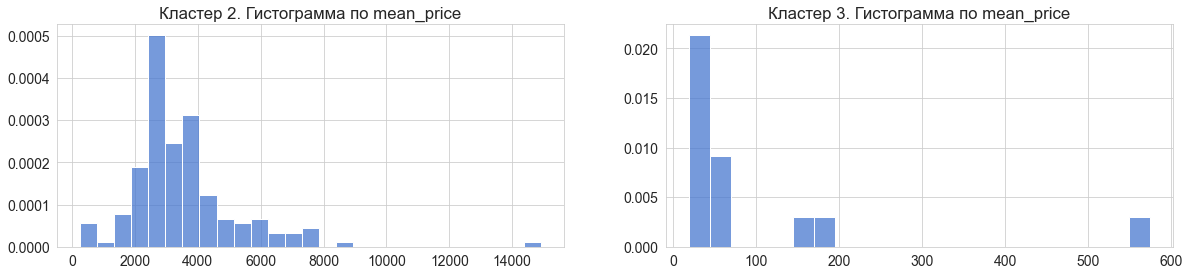

In [58]:
# посмотрим на распределение наших выборок
hist_plot_combin(df_encoded_concat, ['mean_price'])

Т.к. распределения всех выборок далеки от нормального, проверим, как распределены их выборочные средние.

  0%|          | 0/6 [00:00<?, ?it/s]

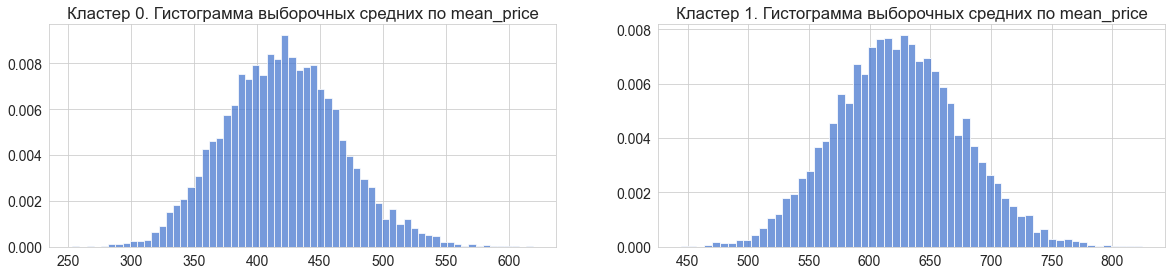

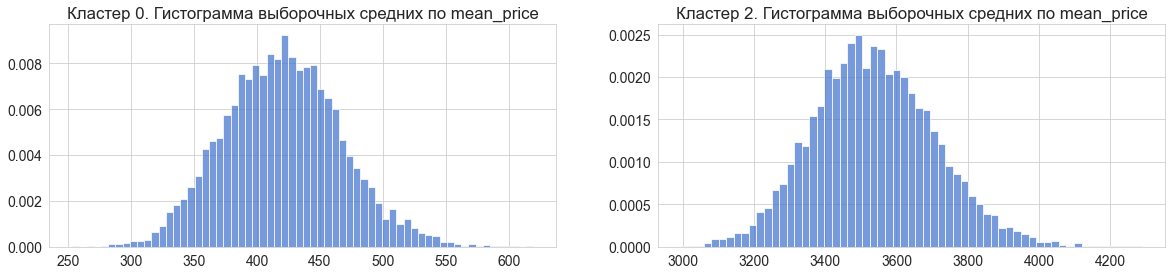

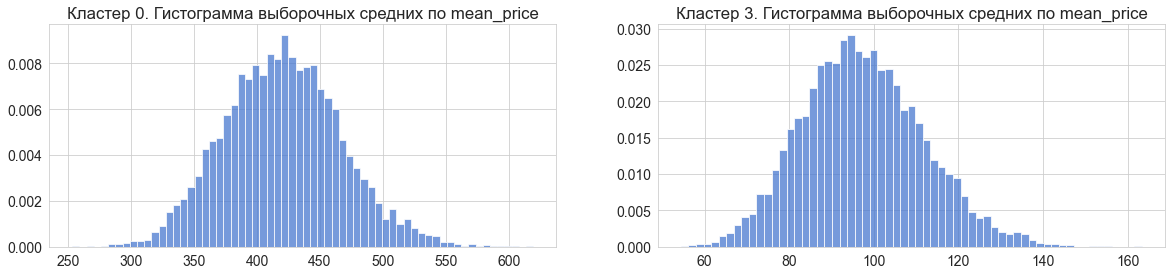

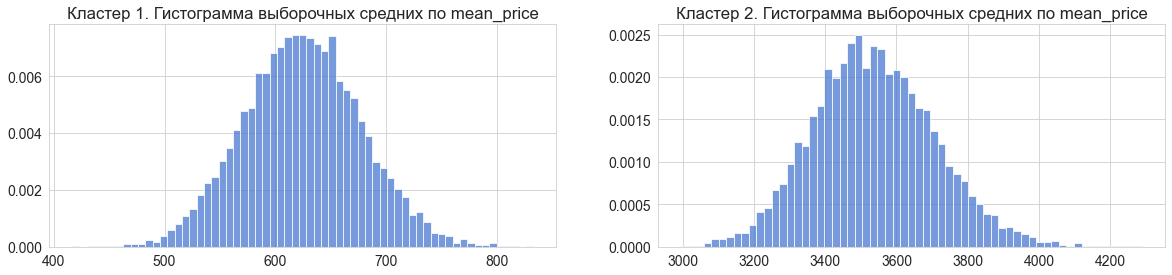

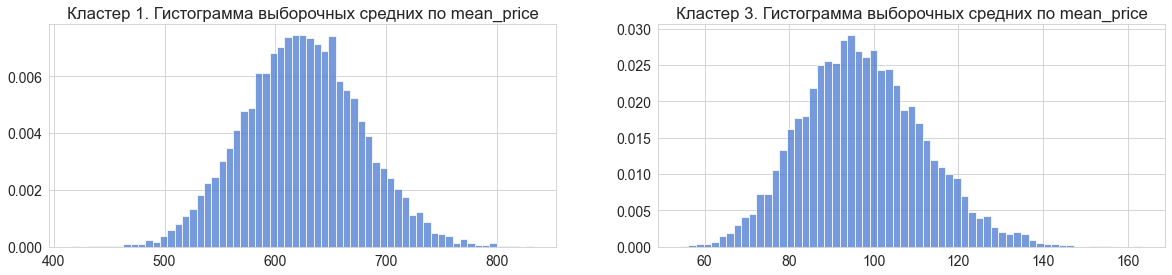

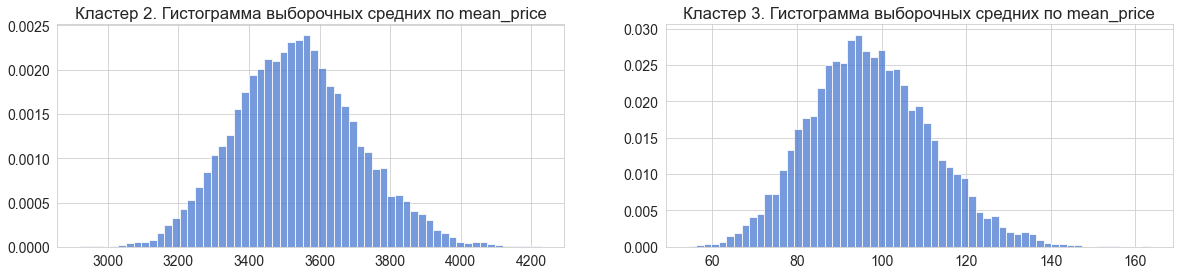

In [59]:
# проведем ряд экспериментов с выборочными средними
check_sample_avg_combin(df_encoded_concat, 'mean_price')

Видим, что распределения выборочных средних близки к нормальным; но, также, знаем, что одна из наших выборок слишком маленького размера для применения T-теста. Поэтому воспользуемся тестом Манна-Уитни.

In [60]:
# проведем ряд стат. тестов
make_m_test_combin(df_encoded_concat, 'mean_price', m=6) 

  0%|          | 0/6 [00:00<?, ?it/s]

Результаты теста 1. Кластеры: 0 и 1
p-value: 1.2855265499482204e-30
Отвергаем нулевую гипотезу
Результаты теста 2. Кластеры: 0 и 2
p-value: 3.272086711456584e-93
Отвергаем нулевую гипотезу
Результаты теста 3. Кластеры: 0 и 3
p-value: 4.933773858900778e-05
Отвергаем нулевую гипотезу
Результаты теста 4. Кластеры: 1 и 2
p-value: 1.554392201809977e-84
Отвергаем нулевую гипотезу
Результаты теста 5. Кластеры: 1 и 3
p-value: 2.28018944351831e-07
Отвергаем нулевую гипотезу
Результаты теста 6. Кластеры: 2 и 3
p-value: 2.3466172983317954e-09
Отвергаем нулевую гипотезу


**Вывод:** В средней цене купленных товаров у покупателей из всех наших кластеров есть статистически значимые различия.

## Выводы

В результате проведенного анализа мы получили четыре статистически значимо отличающихся друг от друга сегмента покупателей интернет-магазина товаров для дома «Пока все ещё тут».

### Кластер 0
Наиболее крупный по количеству покупателей в нем (1296 человек). Эти покупатели заказывали небольшое количество недорогих товаров; как следствие - имеют низкий средний чек; в основном заказывали в магазине лишь единожды. Самая популярная категория покупок - растения (63% от всех покупок). На втором месте - недорогие хозтовары - это хозтовары, которые дешевле 1000 (21% от всех покупок). В месяцы с марта по июль основная доля покупок приходится на растения. В остальное время года - это недорогие хозтовары, комнатные растения.
- Средний чек покупателей: 900. 
- Среднее количество заказов, сделанных покупателем: 1. 
- Средняя цена купленного товара: 420. 
- Среднее количество заказанных покупателем товаров: 3.

Покупатели из этого кластера малоперспективны для настройки рекомендательных рассылок. Такой покупатель оформил только один небольшой заказ на маленькую сумму. Если, все же, формировать рассылку для покупателей из этого кластера, то им можно предложить скидки и бонусы за оформление второго заказа на уличные растения и атрибуты для ухода за ними (из категории недорогие хозтовары). Рассылку следует проводить в период с марта по июль. В остальное время года, можно предложить скидки и бонусы за оформление второго заказа на недорогие хозтовары, реже - на комнатные растения.

### Кластер 1
Похож на нулевой кластер. Крупный по количеству покупателей в нем (800 человек). Эти покупатели заказывали небольшое количество недорогих товаров; как следствие - имеют низкий средний чек. Часто возвращались за второй и последующими покупками в магазин. Самая популярная категория покупок - растения (45% от всех покупок). На втором месте - недорогие хозтовары (25% от всех покупок). В месяцы с апреля по июнь основная доля покупок приходится на растения. В остальное время года - это недорогие и дорогие хозтовары, комнатные растения.
- Средний чек покупателей: 701. 
- Среднее количество заказов, сделанных покупателем: 2. 
- Средняя цена купленного товара: 624. 
- Среднее количество заказанных покупателем товаров: 1.

Покупатели из этого кластера, также, малоперспективны для настройки рекомендательных рассылок. Такой покупатель хоть и возвращался второй раз за покупкой, но она была также мала как и первая. Если, все же, формировать рассылку для покупателей из этого кластера, то им можно предложить уличные растения и атрибуты для ухода за ними (из категории недорогие хозтовары). Рассылку следует проводить в период с апреля по июнь. В остальное время года, можно предложить комнатные растения и недорогие хозтовары.

### Кластер 2
Небольшой по количеству покупателей в нем (165 человек). Эти покупатели заказывали небольшое количество дорогих товаров; имеют высокий средний чек; в основном заказывали в магазине лишь единожды. Самая популярная категория покупок - дорогие хозтовары - это хозтовары, которые дороже 1000 (62% от всех покупок). Покупки не зависят от сезона.
- Средний чек покупателей: 4507. 
- Среднее количество заказов, сделанных покупателем: 1. 
- Средняя цена купленного товара: 3537. 
- Среднее количество заказанных покупателем товаров: 1.

Покупатели из этого кластера весьма перспективны для настройки рекомендательных рассылок. Такой покупатель оформил один небольшой заказ на крупную сумму. Им можно предложить скидки и бонусы за оформление второго заказа на дорогие хозтовары (дороже 1000). Или порекомендовать новые поступления товаров из этих категорий. Рассылку можно проводить в любое время года. 

### Кластер 3
Самый маленький по количеству покупателей в нем (13 человек). Эти покупатели заказывали большое количество недорогих товаров; средний чек у них высокий; в основном заказывали в магазине лишь единожды. Самая популярная категория покупок - недорогие хозтовары (89% от всех покупок). Оставшиеся 11% приходятся на кухонные принадлежности. Покупки не зависят от сезона.
- Средний чек покупателей: 13292. 
- Среднее количество заказов, сделанных покупателем: 1. 
- Средняя цена купленного товара: 97. 
- Среднее количество заказанных покупателем товаров: 143.

Покупатели из этого кластера весьма перспективны для настройки рекомендательных рассылок. Такой покупатель оформил один большой заказ из мелких товаров на крупную сумму. Им можно предложить скидки и бонусы за оформление нового заказа на большое количество недорогих хозтоваров. Или скидки и бонусы за оформление второго заказа на недорогие хозтовары. Или порекомендовать новые поступления товаров из этих категорий. Рассылку можно проводить в любое время года. 